# Analyzing Contextualized Models

In the previous step, we applied applied contextualized linear regression models to diabetes data. Here, we analyze these models to determine homogeneous and heterogeneous predictors of diabetes progression, i.e. what predictors are consistent across patients vs. what predictors change according to an individual's context.

In [1]:
# Reload the same data as before
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes

# Load data
X, Y = load_diabetes(return_X_y=True, as_frame=True)
Y = np.expand_dims(Y.values, axis=-1)

# Decide context variables, or use other paired data as context
C = X[['age', 'sex', 'bmi']]
X.drop(['age', 'sex', 'bmi'], axis=1, inplace=True)

# Create a hold-out test set
seed = 1
C_train, C_test, X_train, X_test, Y_train, Y_test = train_test_split(C, X, Y, test_size=0.20, random_state=seed)

# Normalize the data
def normalize(train, test):
    mean = train.mean()
    std = train.std()
    train = (train - mean) / std
    test = (test - mean) / std
    return train, test
X_train, X_test = normalize(X_train, X_test)
C_train, C_test = normalize(C_train, C_test)
Y_train, Y_test = normalize(Y_train, Y_test)

## Load the trained model

In [3]:
from contextualized.utils import load

model = load('my_contextualized_model.pt')

## Inspect the model predictions.

We can use standard plotting tools to inspect the model predictions.

In [4]:
%%capture
Y_pred = model.predict(C_test.values, X_test.values)

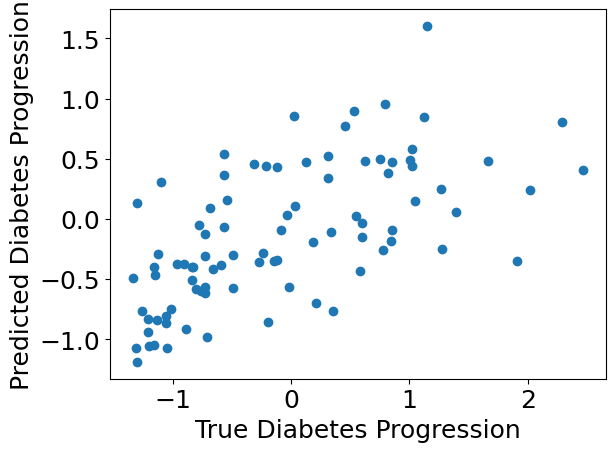

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})

plt.scatter(Y_test, Y_pred)
plt.xlabel("True Diabetes Progression")
plt.ylabel("Predicted Diabetes Progression")
plt.show()

## Check how the individual bootstrap models learned.

Since we're bootstrapping for robustness, we can also access individual bootstrap runs with the `individual_preds` keyword to get confidence intervals. 
Below we plot the standard deviation for each one of the test-point predictions.

In [12]:
%%capture
Y_preds = model.predict(C_test.values, X_test.values, individual_preds=True)
Y_preds.shape  # (n_bootstraps, n_samples, n_outputs)

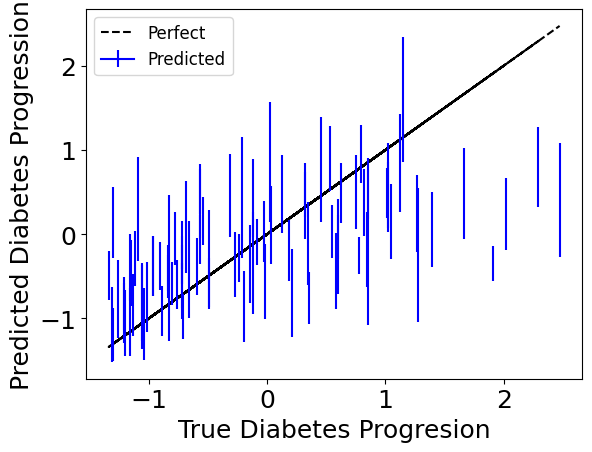

In [43]:
# Squeeze the n_output dimension, we only have one output here.
Y_test = Y_test.squeeze()
Y_preds = Y_preds.squeeze()

plt.plot(Y_test, Y_test, color='black', linestyle='--', label='Perfect')
# Set the legend entry using the first datapoint. The rest will be the same.
plt.errorbar(Y_test[0], np.mean(Y_preds[:, 0], axis=0),
            yerr=2*np.std(Y_preds[:, 0], axis=0), color='blue',
            label='Predicted')
# Make scatter plot points with only error bars
for i in range(Y_preds.shape[1]):
    plt.errorbar(Y_test[i], np.mean(Y_preds[:, i], axis=0),
                yerr=2*np.std(Y_preds[:, i], axis=0), color='blue')
plt.xlabel("True Diabetes Progresion")
plt.ylabel("Predicted Diabetes Progression")
plt.legend(fontsize=12)
plt.show()

## Check what effects the models learned.

Now, let's look at the contextualized models we're using to make these predictions. 
We can extract the predicted context-specific model parameters and visualize them to see what effects the models learned.
To get a sense of how the models are clustered and how contexts affect parameters, let's embed the model parameters in a 2-D space and visualize them according to each context feature.

In [25]:
%%capture
coefs, offsets = model.predict_params(C.values, individual_preds=False)
coefs.shape # (n_samples, n_outputs, n_predictors)
offsets.shape  # (n_samples, n_outputs)

# Contextualized linear regression coefficients are shape:
# (n_samples, n_outputs, n_predictors)
# Let's squeeze out the n_outputs axis since we only have 1 output in this example.
coefs = np.squeeze(coefs)

# Any embedding method could be used; here we will use UMAP.
from umap import UMAP
um = UMAP(n_neighbors=5)
model_reps = um.fit_transform(coefs)

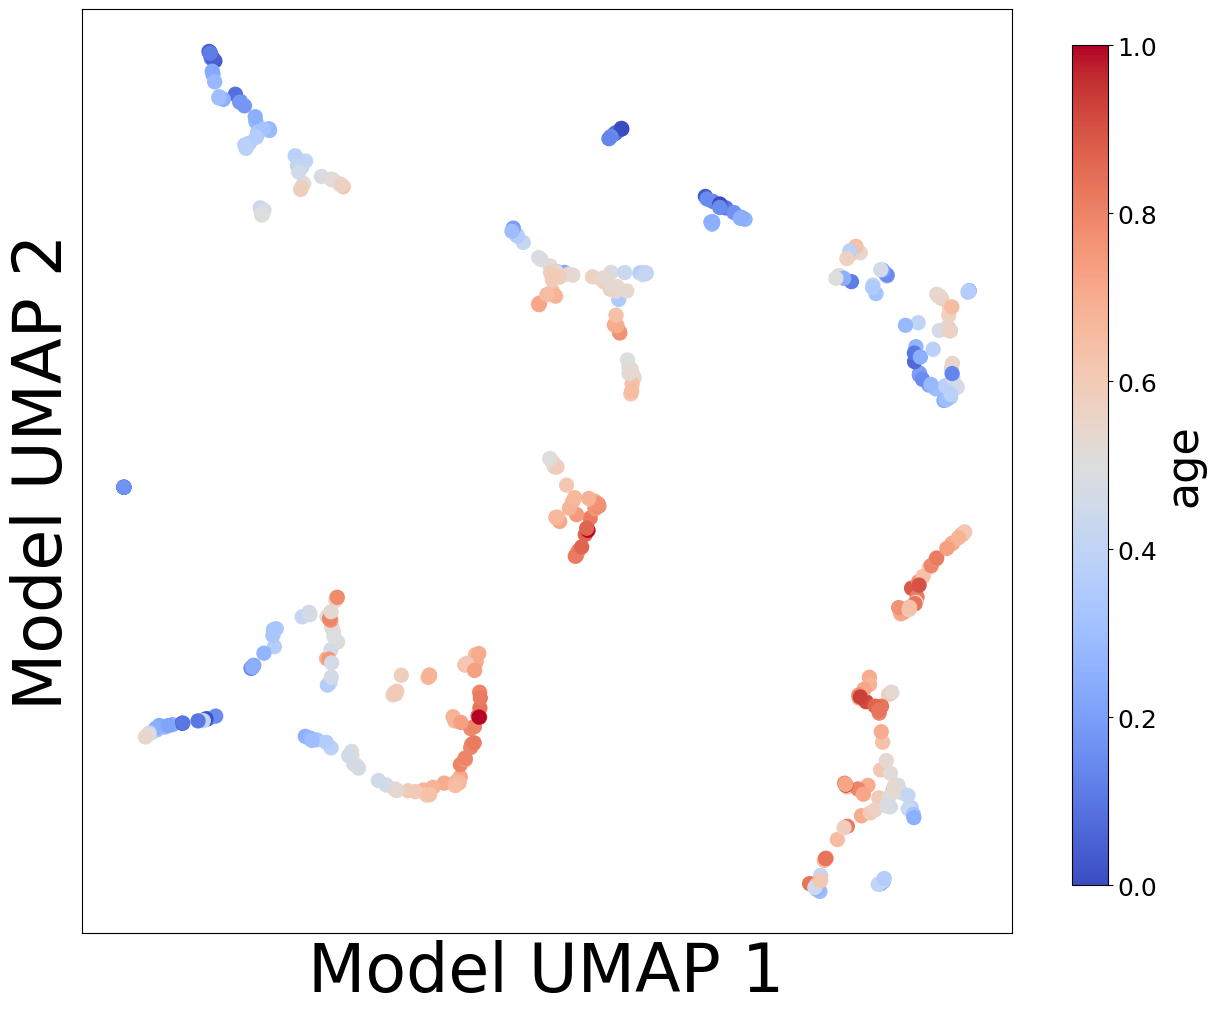

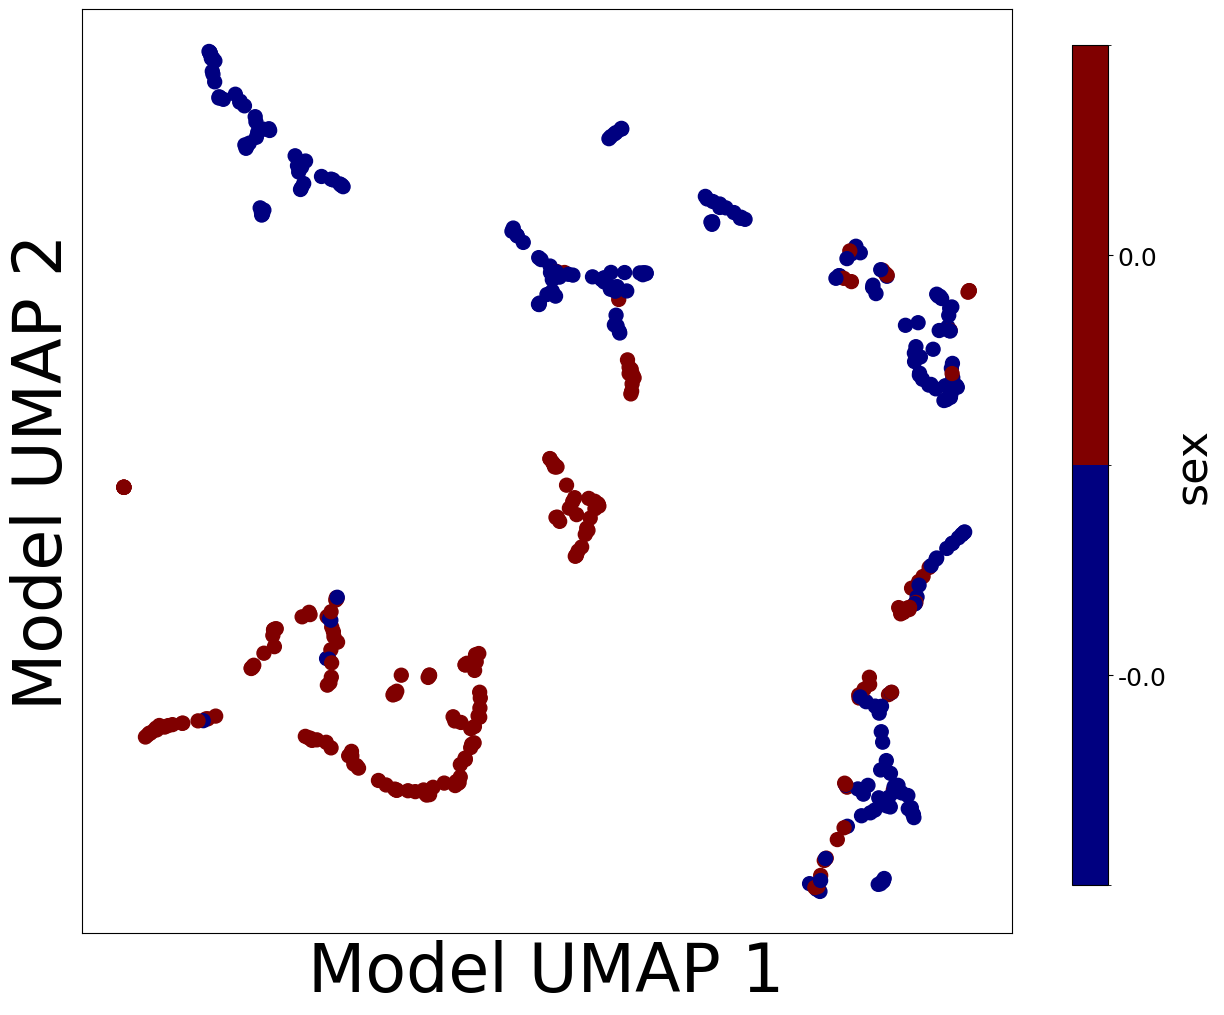

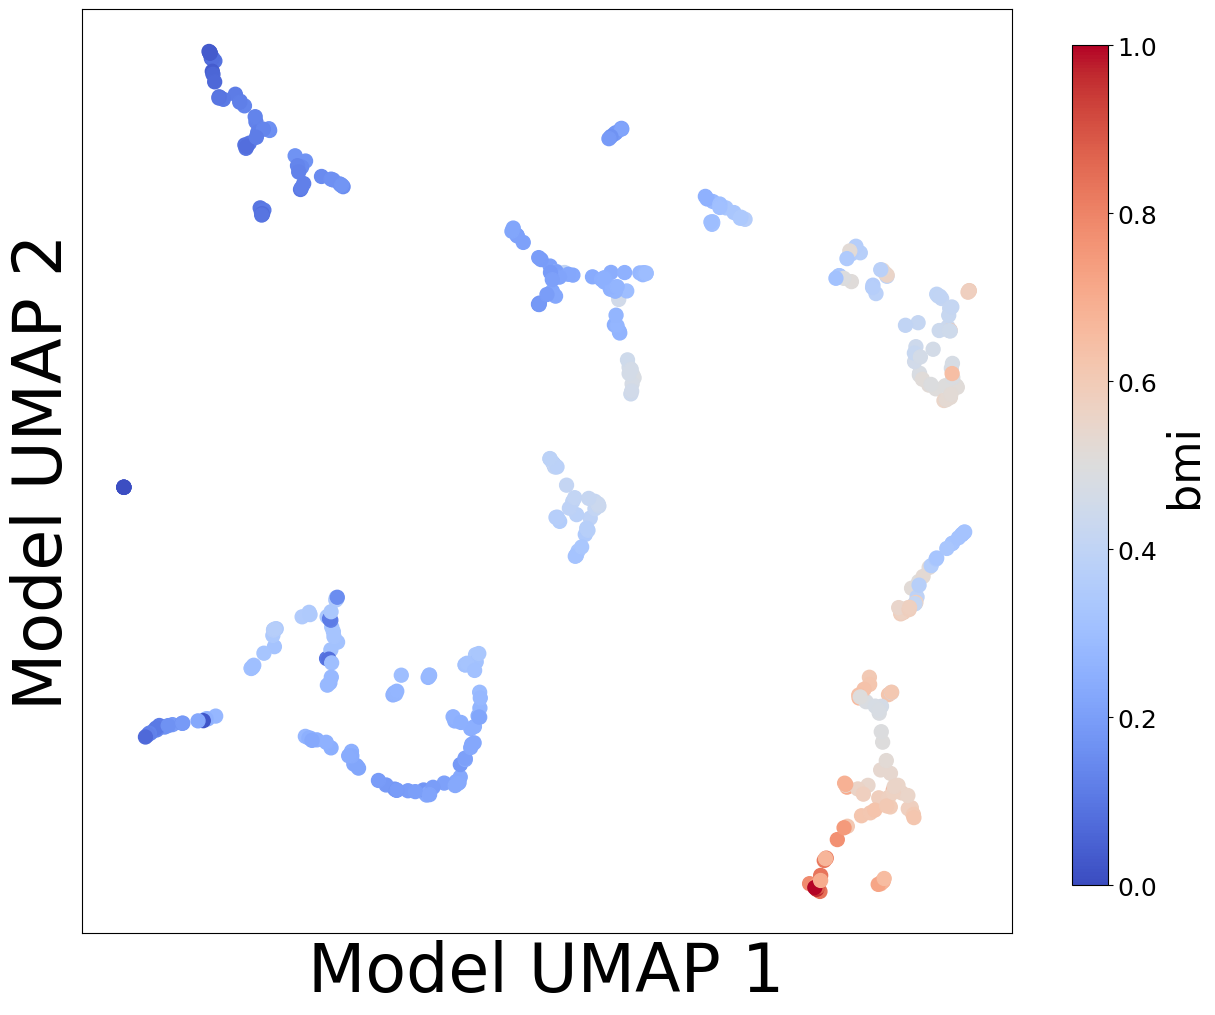

In [26]:
# A simple helper function is provided in the analysis toolkit for plotting embeddings.
from contextualized.analysis.embeddings import plot_embedding_for_all_covars
plot_embedding_for_all_covars(model_reps, C, xlabel='Model UMAP 1', ylabel='Model UMAP 2')

## Homogeneous vs. Heterogeneous Effects

Now let's really dig in and try to tease apart homogeneous (context-invariant) and heterogeneous (context-dependent) effects.
This is a primary goal of contextualized modeling: to understand how different predictors are affected by different contexts, and use this information to make better predictions.

Before diving in, let's first understand the structure of the model.

### What is a Model
A parametric statistical model can be written as a probability distribution $P$ over the data $X$, defined by some parameters $\theta$.

$$P(X | \theta)$$

For example, a linear regression model is

$$P(Y | X, \theta) = \mathcal{N}(Y | X\beta + \mu, \sigma^2) \propto \exp(\frac{1}{2\sigma^2}(Y - X\beta - \mu)^2)$$

where $\beta$ are the regression coefficients, $\mu$ is the offset of the model, $X\beta + \mu$ is the $X$-conditioned mean of $Y$, and $\sigma^2$ is the variance/error around the mean Y.

### What is a Contextualized Model
In a contextualized model, the parameters $\theta$ are themselves functions of some context $C$.

$$P(X | \theta(C))$$

For linear regression, this becomes

$$P(Y | X, \theta(C)) = \mathcal{N}(Y | X\beta(C) + \mu(C), \sigma^2)$$

Now, the regression coefficients $\beta(C)$ and the offset $\mu(C)$ are functions of the context $C$. 
But not all parameters will depend on context; some may not change.
Let's call the regression coefficients which depend on context $\beta(C)$ and the ones which don't $\beta$.

$$P(Y | X, \theta(C)) = \mathcal{N}(Y | X\beta + X\beta(C) + \mu(C), \sigma^2)$$

Assuming the data is already normalized we don't need to split $\mu(C)$. 
Notice that there are three types of effects in contextualized models:
- Homogeneous Context Effects $\mu(C)$: Effects directly from context which do not depend on predictors.
- Homogeneous Predictor Effects $\beta$: Effects from predictors which do not depend on context.
- Heterogeneous Predictor Effects $\beta(C)$: Effects from predictors which are modulated by context.

### Testing for Homogeneous and Heterogeneous Effects
Now that these effects are specified, we can identify and visualize them based on a parameter's context-dependence or context-independence, or as a direct contextual effect.
Furthermore, we can test them and quanitfy certainty in the effect based on the estimates from each of the bootstrap runs.


## Plotting Homogeneous and Heterogeneous Effects
Helper analysis tools are provided to analyze each of these effects by:
- getting the values of the effects for a domain of context
- plotting the values of the effect for a domain of context
- calculating p-values of the effect for a domain of context

In [27]:
from contextualized.analysis.effects import (
    plot_homogeneous_context_effects,
    plot_homogeneous_predictor_effects,
    plot_heterogeneous_predictor_effects,
)

from contextualized.analysis.pvals import (
    calc_homogeneous_context_effects_pvals,
    calc_homogeneous_predictor_effects_pvals,
    calc_heterogeneous_predictor_effects_pvals
)

## Homogeneous Context Effects of Diabetes Progression

First, we can see the homogeneous (direct) effects of context on diabetes progression.

/opt/homebrew/Caskroom/miniforge/base/envs/contextualized310dev/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


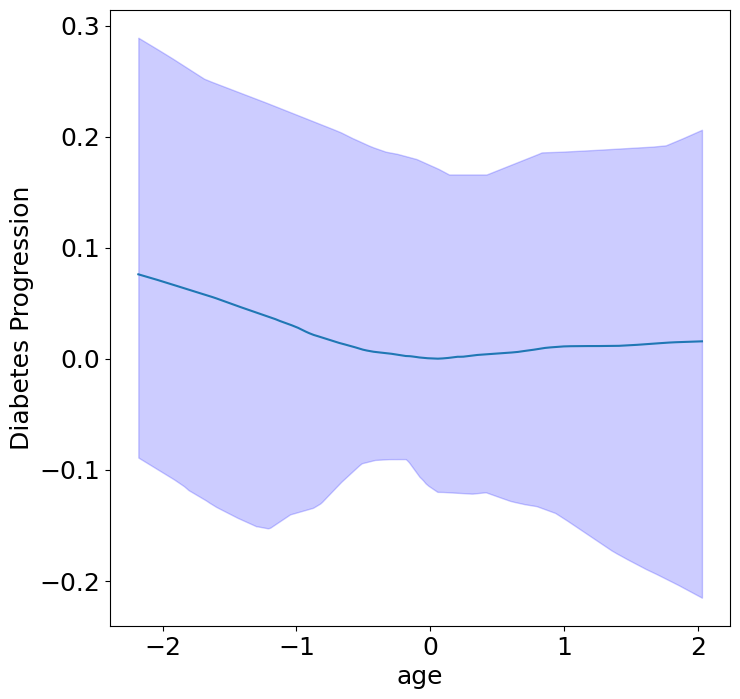

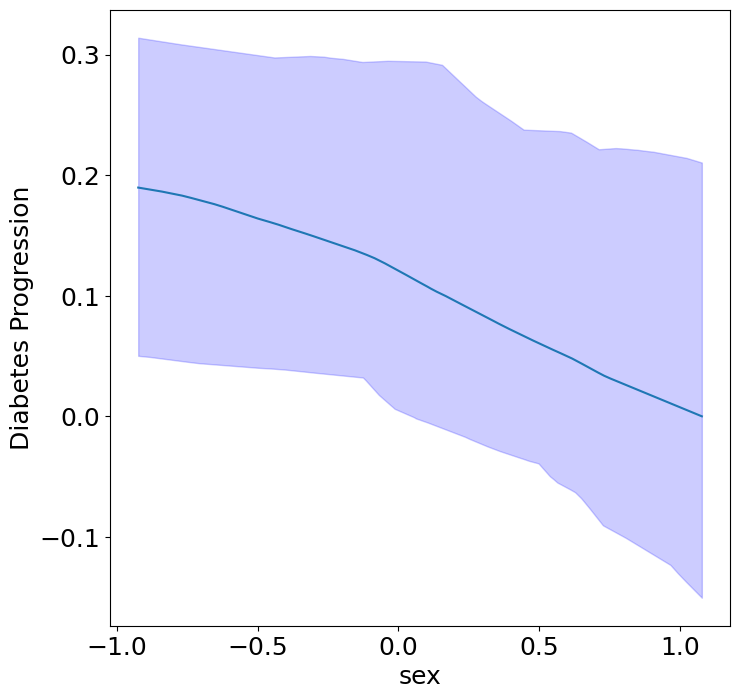

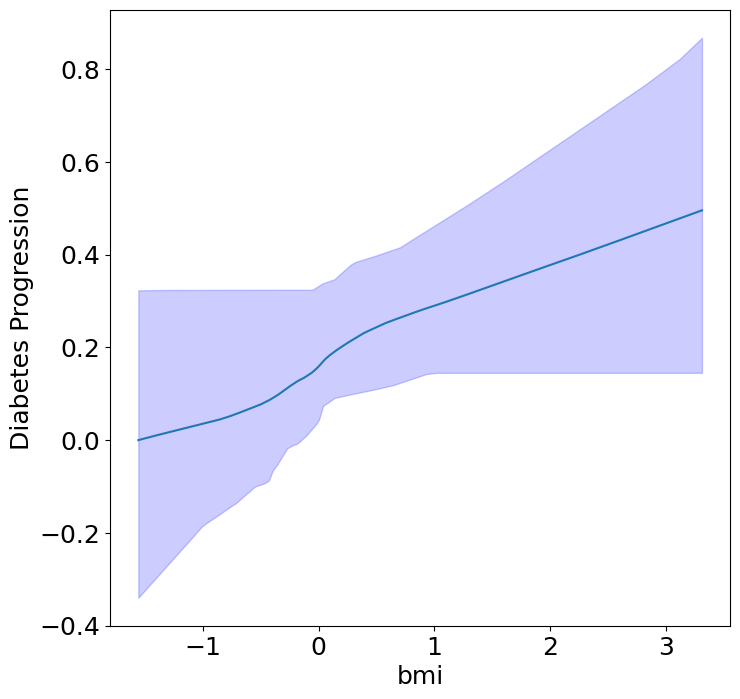

In [29]:
plot_homogeneous_context_effects(
    model, C_test, classification=False,
    ylabel="Diabetes Progression", verbose=False)

In [30]:
%%capture
# We can quantify the uncertainty visualized in the bootstrap confidence intervals
# by measuring p-values of the consistency of the estimated sign of each effect.
homogeneous_context_pvals = calc_homogeneous_context_effects_pvals(model, C_test)
context_pvals = pd.DataFrame(np.array([
   [C_test.columns[i], pval[0]] for i, pval in enumerate(homogeneous_context_pvals)
]), columns=["Context Variable", "p-value"])

In [31]:
context_pvals
# Notice that the p-values are calculated from bootstrap resampling,
# so they are limited by the number of bootstraps used.
# Caution: using more bootstraps could artificially inflate confidence.

,Context Variable,p-value
0,age,0.3333333333333333
1,sex,0.047619047619047616
2,bmi,0.047619047619047616


## Homogeneous Predictor Effects on Diabetes Progression

Next, we can see the homogeneous effects of the predictors on progression.

/opt/homebrew/Caskroom/miniforge/base/envs/contextualized310dev/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


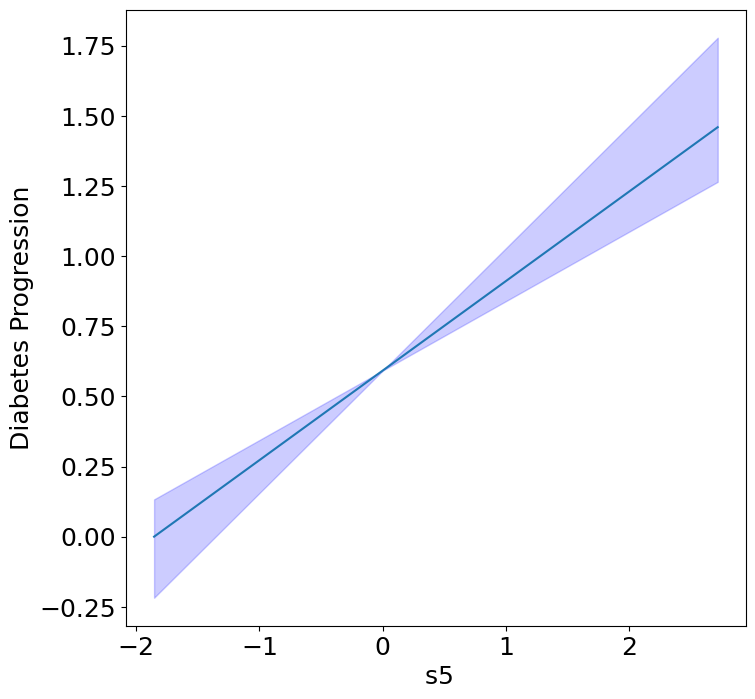

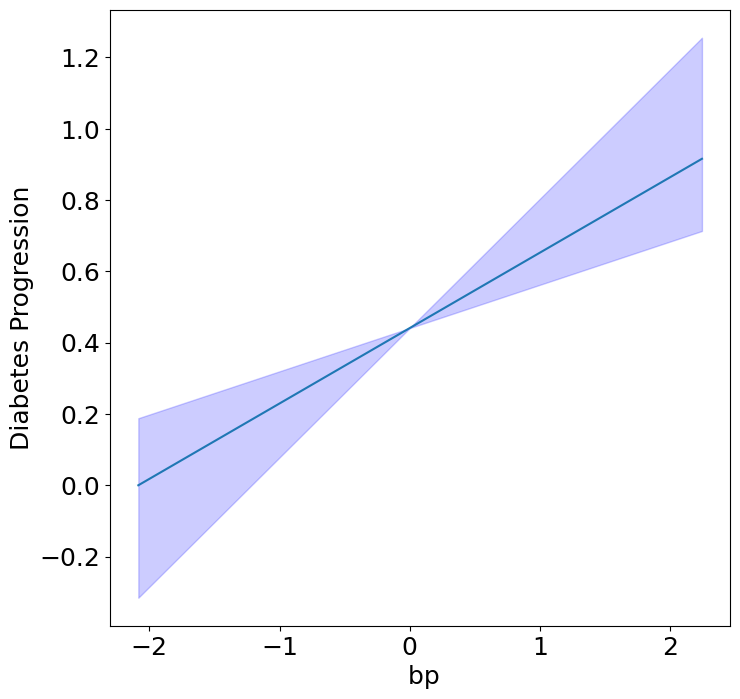

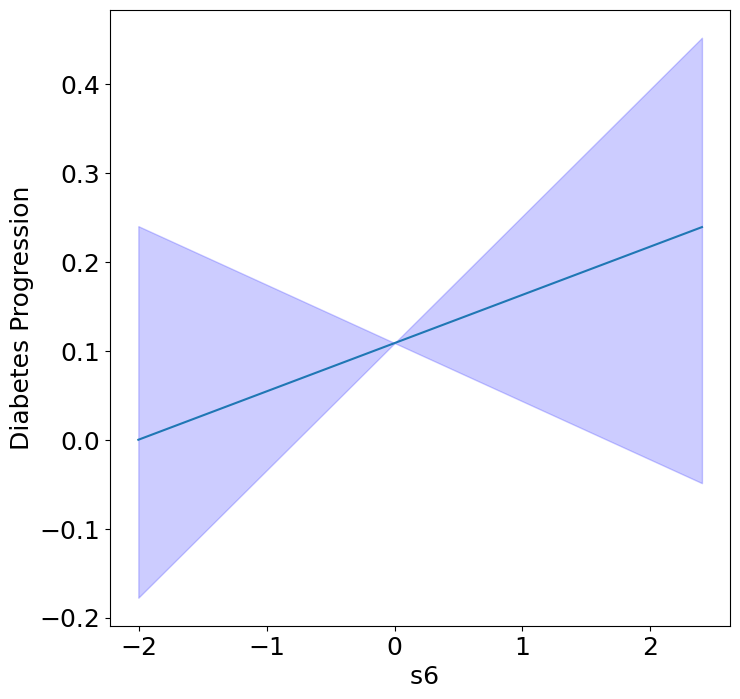

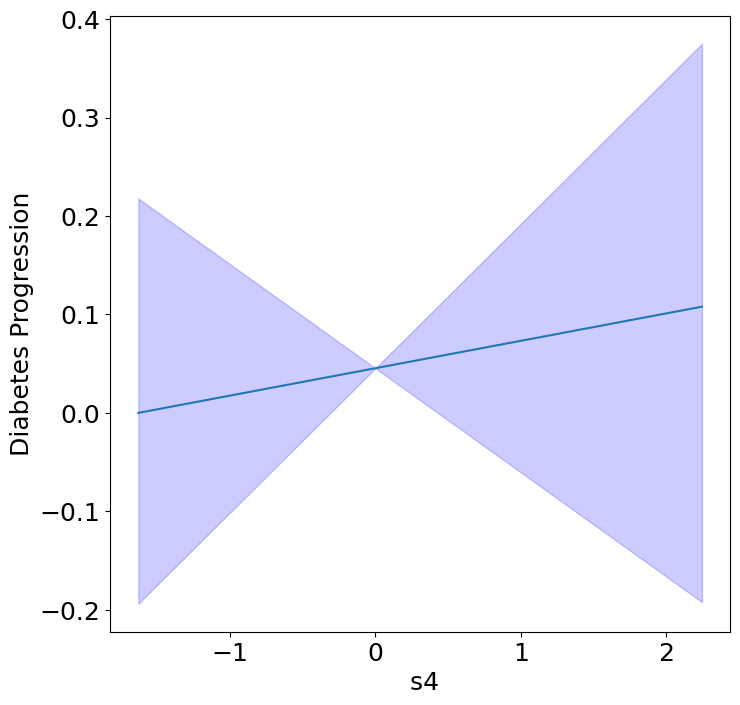

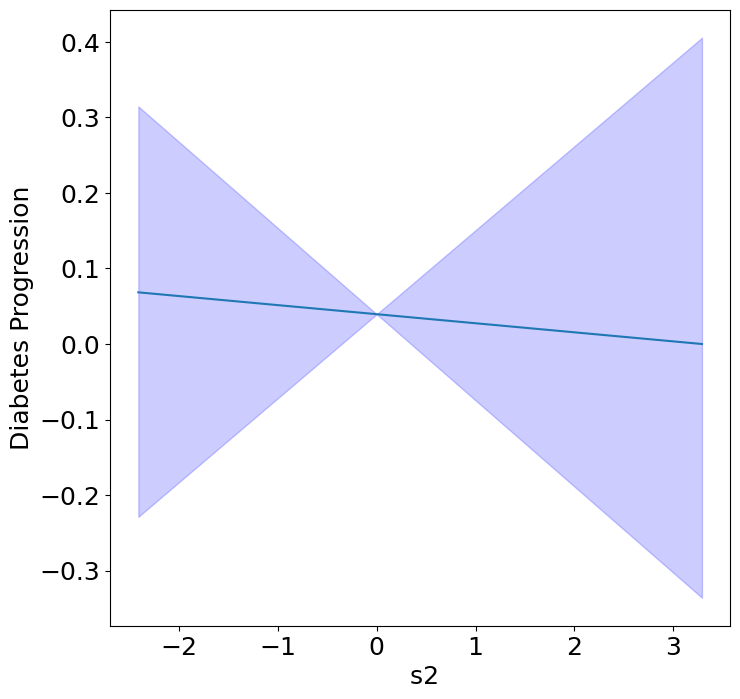

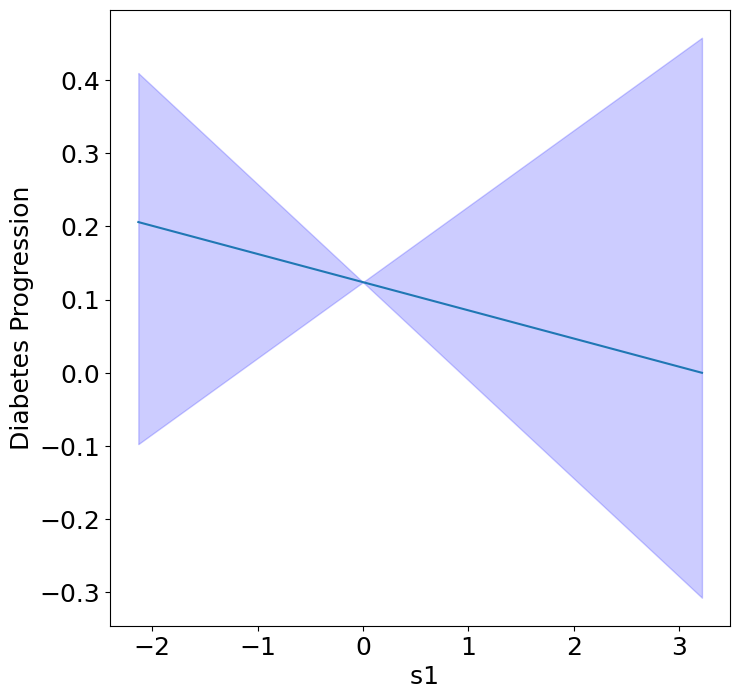

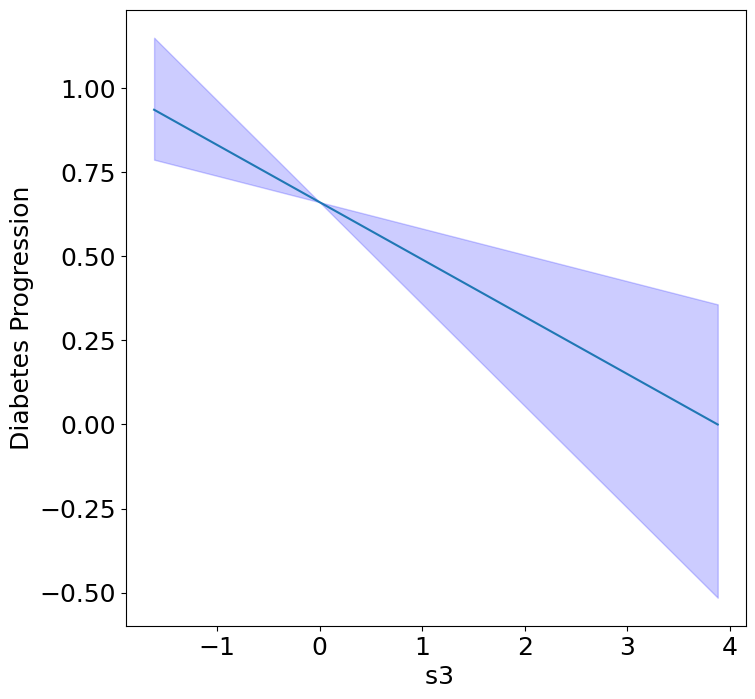

In [32]:
plot_homogeneous_predictor_effects(
    model, C_test, X_test,
    ylabel="Diabetes Progression",
    classification=False)

In [33]:
%%capture
# We can quantify the uncertainty visualized in the bootstrap confidence intervals
# by measuring p-values of the consistency of the estimated sign of each effect.
homogeneous_predictor_pvals = calc_homogeneous_predictor_effects_pvals(model, C_test)
predictor_pvals = pd.DataFrame(np.array([
   [X_test.columns[i], pval[0]] for i, pval in enumerate(homogeneous_predictor_pvals)
]), columns=["Predictor", "p-value"])

In [34]:
predictor_pvals

,Predictor,p-value
0,bp,0.047619047619047616
1,s1,0.14285714285714285
2,s2,0.42857142857142855
3,s3,0.047619047619047616
4,s4,0.47619047619047616
5,s5,0.047619047619047616
6,s6,0.19047619047619047


## Heterogeneous Predictor Effects on Diabetes Progression

Finally, we can see the heterogeneous effects of the predictors on progression.

Generating datapoints for visualization by assuming the encoder is
            an additive model and thus doesn't require sampling on a manifold.
            If the encoder has interactions, please supply C_vis so that we
            can visualize these effects on the correct data manifold.


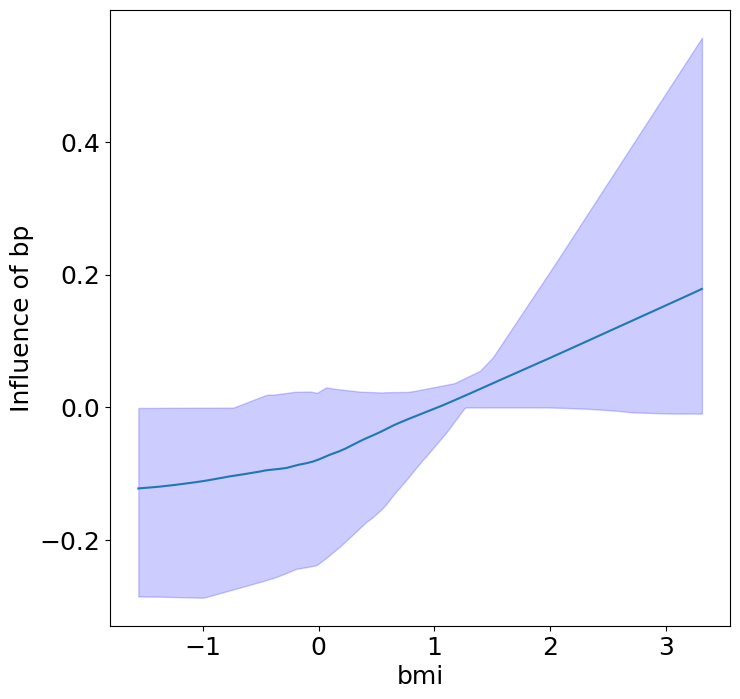

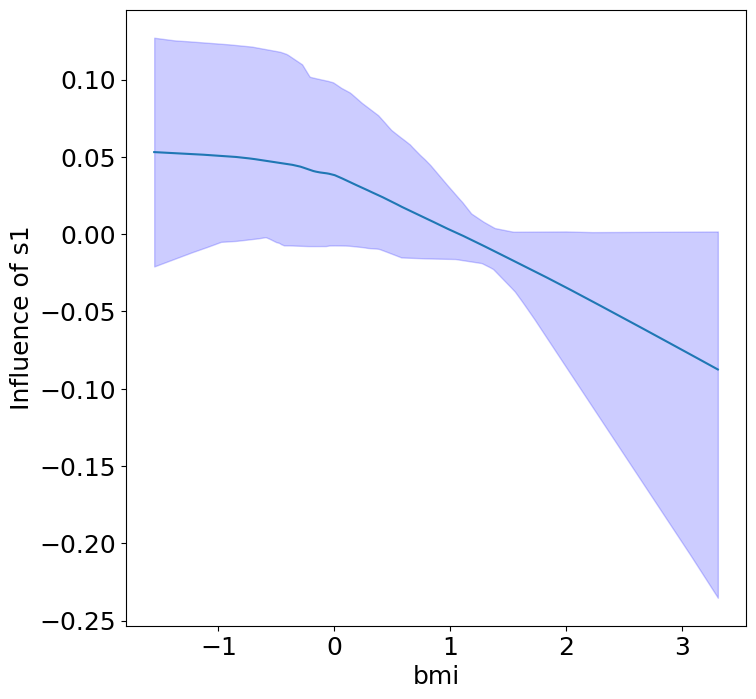

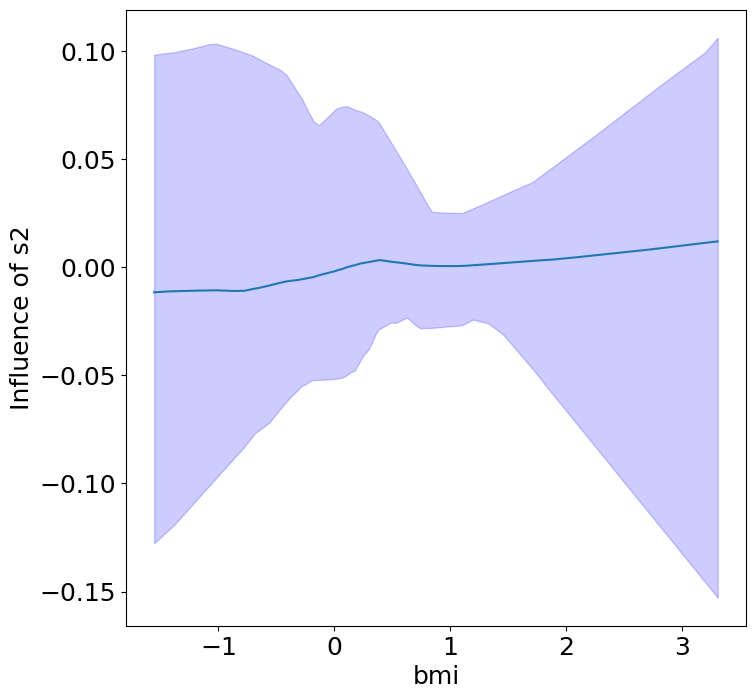

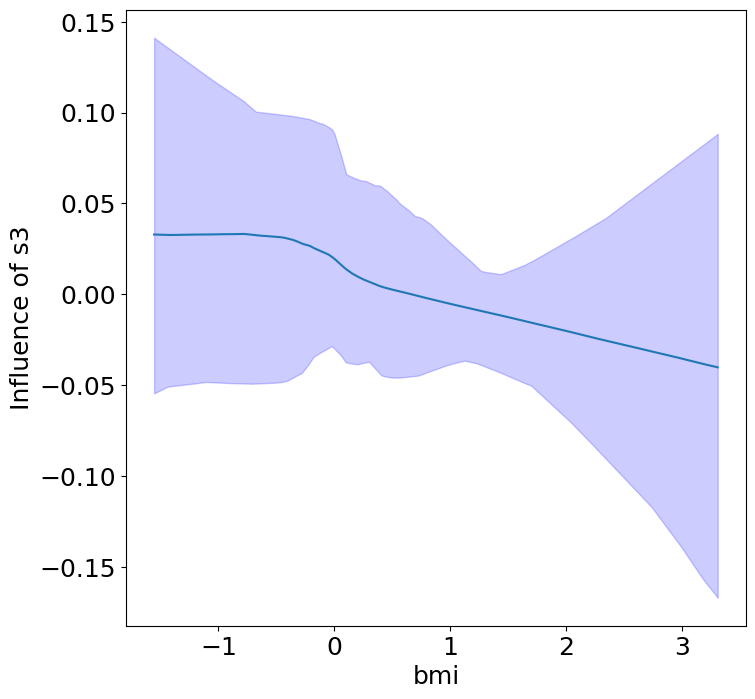

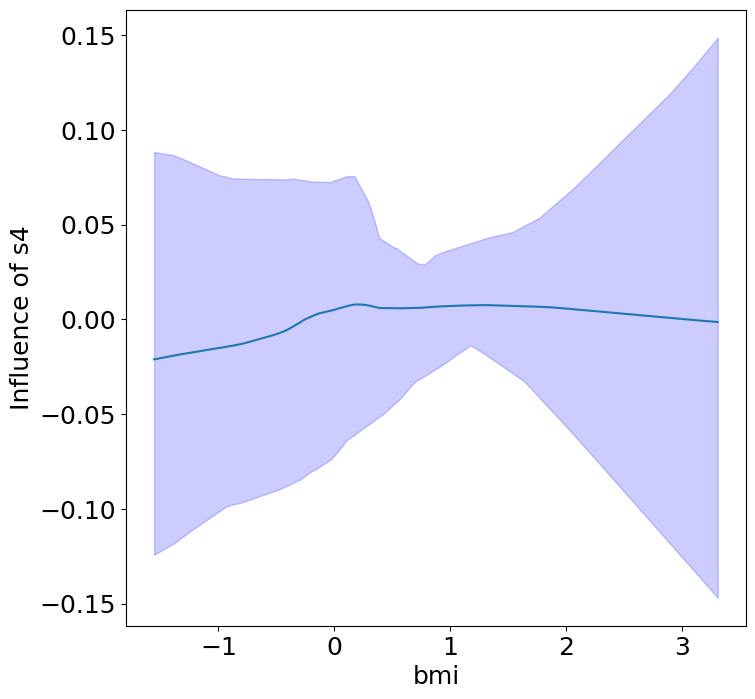

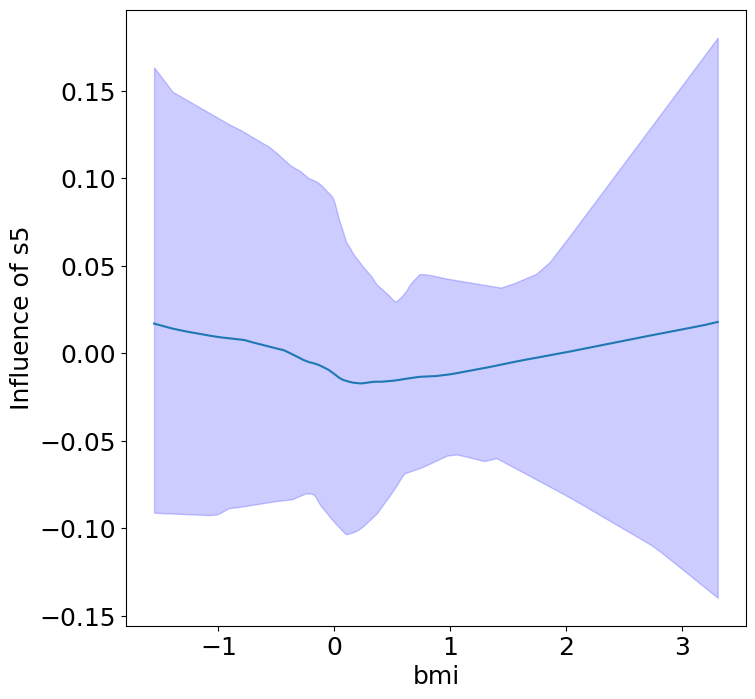

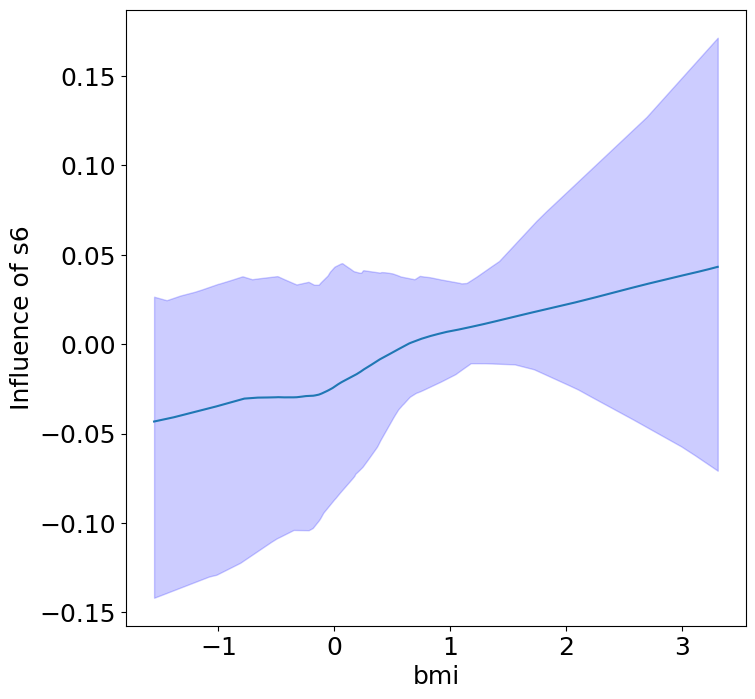

In [39]:
plot_heterogeneous_predictor_effects(model, C_test, X_test, min_effect_size=0.1,
                  ylabel="Influence of")
# Since there are a combinatorial number of heterogeneous predictor effects,
# min_effect_size is a useful parameter to restrict the plotting to
# only the strongest effects.

In [40]:
%%capture
# We can quantify the uncertainty visualized in the bootstrap confidence intervals
# by measuring p-values of the consistency of the estimated sign of each effect.
# This is a combinatorial: context x predictor
heterogeneous_predictor_pvals = calc_heterogeneous_predictor_effects_pvals(model, C_test)
predictor_pvals = pd.DataFrame(np.array([
   [C_test.columns[i // len(X.columns)], X_test.columns[i % len(X.columns)], pval] for i, pval in enumerate(heterogeneous_predictor_pvals.flatten())
]), columns=["Context", "Predictor", "p-value"])

In [41]:
predictor_pvals

,Context,Predictor,p-value
0,age,bp,0.5238095238095238
1,age,s1,0.42857142857142855
2,age,s2,0.38095238095238093
3,age,s3,0.3333333333333333
4,age,s4,0.5714285714285714
5,age,s5,0.42857142857142855
6,age,s6,0.3333333333333333
7,sex,bp,0.19047619047619047
8,sex,s1,0.14285714285714285
9,sex,s2,0.2857142857142857


## Conclusion
Notice that only bmi appears to contribute to heterogeneity in diabetes progression through bp and s1 (we can increase bootstraps to confirm whether these are significant. 20 bootstraps is the minimum threshold for a P-value <0.05 without correcting for multiple testing).

Key takeaways:
1. BMI modulates the effect of blood pressure and the s1 on diabetes progression. BMI should be controlled for in studies on diabetes, and stratifying groups by BMI may be useful for identifying personalized treatments.
2. Other predictors show context invariance, or are direct effects of context. These predictors can be used to predict diabetes progression in a general population.
3. Contextualization enables us to split these effects without performing many pairwise tests between predictor and context features. All of this was achieved from a single training run, and can be validated by model accuracy.